In [1]:
# -*- coding: utf-8 -*-
# -*- authors : Vincent Roduit -*-
# -*- date : 2025-04-24 -*-
# -*- Last revision: 2025-05-02 by janzgraggen -*-
# -*- python version : 3.10.4 -*-
# -*- Description: Notebook that summarizes the main results-*-

# <center> EE-452: Network Machine Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Graph-based EEG Analysis </center>
---

In [2]:
#import libraries
import pandas as pd
from pathlib import Path
import sys

from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
from seiz_eeg.dataset import EEGDataset

#import modules
import constants
from transform_func import *
from dataloader import load_data
from utils import *
from dataloader import *


%load_ext autoreload
%autoreload 2

/home/nulpe/anaconda3/envs/ada/lib/python3.12/site-packages/torch/__config__.py:9: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._show_config()


In [3]:
data_path = "../data"

DATA_ROOT = Path(data_path)

clips_train = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
clips_test = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

# You can change the signal_transform, or remove it completely
data_train = EEGDataset(
    clips_train,
    signals_root=DATA_ROOT / "train",
    signal_transform=None,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

data_test = EEGDataset(
    clips_test,
    signals_root=DATA_ROOT / "test",
    signal_transform=None,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

In [4]:
clips_train
# Count how often the label is 0 and 1 in clips_train
label_counts = clips_train['label'].value_counts()
print(label_counts)
10476/(10476+2517)

label
0    10476
1     2517
Name: count, dtype: int64


0.8062803047794966

In [ ]:
# Prepare the multi-index DataFrame
import pandas as pd

def get_summary_stats(df):
    df = df.reset_index()
    sessions_per_patient = df.groupby('patient')['session'].nunique()
    segments_per_session = df.groupby(['patient', 'session']).size()
    return {
        'Number of patients': df['patient'].nunique(),
        'sessions_per_patient': {
            'mean': sessions_per_patient.mean(),
            'median': sessions_per_patient.median(),
            'min': sessions_per_patient.min(),
            'max': sessions_per_patient.max()
        },
        'segments_per_session': {
            'mean': segments_per_session.mean(),
            'median': segments_per_session.median(),
            'min': segments_per_session.min(),
            'max': segments_per_session.max()
        }
    }

train_stats = get_summary_stats(clips_train)
test_stats = get_summary_stats(clips_test)

# Build the multi-index table
arrays = [
    ['Train', 'Train', 'Test', 'Test'],
    [train_stats['Number of patients'], train_stats['Number of patients'],
     test_stats['Number of patients'], test_stats['Number of patients']],
    ['sessions_per_patient', 'segments_per_session', 'sessions_per_patient', 'segments_per_session']
]
index = pd.MultiIndex.from_arrays(arrays, names=['Set', 'Number of patients', 'Statistic'])

data = [
    [train_stats['sessions_per_patient']['mean'], train_stats['sessions_per_patient']['median'],
     train_stats['sessions_per_patient']['min'], train_stats['sessions_per_patient']['max']],
    [train_stats['segments_per_session']['mean'], train_stats['segments_per_session']['median'],
     train_stats['segments_per_session']['min'], train_stats['segments_per_session']['max']],
    [test_stats['sessions_per_patient']['mean'], test_stats['sessions_per_patient']['median'],
     test_stats['sessions_per_patient']['min'], test_stats['sessions_per_patient']['max']],
    [test_stats['segments_per_session']['mean'], test_stats['segments_per_session']['median'],
     test_stats['segments_per_session']['min'], test_stats['segments_per_session']['max']],
]

summary = pd.DataFrame(data, index=index, columns=['Mean', 'Median', 'Min', 'Max'])

# Output as LaTeX table
print(summary.to_latex(float_format="%.2f"))

\begin{tabular}{lllrrrr}
\toprule
 &  &  & Mean & Median & Min & Max \\
Set & Number of patients & Statistic &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Train} & \multirow[t]{2}{*}{97} & sessions_per_patient & 1.82 & 1.00 & 1 & 7 \\
 &  & segments_per_session & 73.41 & 62.00 & 1 & 285 \\
\cline{1-7} \cline{2-7}
\multirow[t]{2}{*}{Test} & \multirow[t]{2}{*}{25} & sessions_per_patient & 2.00 & 1.00 & 1 & 7 \\
 &  & segments_per_session & 72.28 & 54.00 & 3 & 470 \\
\cline{1-7} \cline{2-7}
\bottomrule
\end{tabular}



*Average signals for data section (not finished)*

In [ ]:
def is_not_mostly_zero_record_test(eeg, threshold=0.05):
  
    signal_magnitude = np.sum(np.abs(eeg), axis=1)
    assert signal_magnitude.shape == (3000,), f"Expected shape (3000,), got {signal_magnitude.shape}"
    length = len(signal_magnitude)
    zeros = (signal_magnitude== 0).sum()

    return (zeros / length) < threshold


In [ ]:
mask = [is_not_mostly_zero_record_test(data_train[i][0]) for i in range(len(data_train)) ]
valid_indices = np.where(mask)[0]

dataset_cleaned = torch.utils.data.Subset(data_train, val_indices).dataset
lables = dataset_cleaned.get_label_array()

#get idx of class 0
idx_class_0 = np.where(lables == 0)[0]
idx_class_1 = np.where(lables == 1)[0]

dataset_cleaned_0 = torch.utils.data.Subset(dataset_cleaned, idx_class_0).dataset
dataset_cleaned_1 = torch.utils.data.Subset(dataset_cleaned, idx_class_1).dataset


In [ ]:

eeg_0 = dataset_cleaned_0[0][0].T 
eeg_1 = dataset_cleaned_1[0][0].T 

signal_magnitude = np.sum(np.abs(eeg_0), axis=0)
length = len(signal_magnitude)
zeros = (signal_magnitude== 0).sum()
zeros/length

*Visualize adjacency matrixes of different graph construction methods* 


In [5]:
os.chdir('/home/nulpe/Desktop/nml/EE452-Network-Machine-Learning/')

Path = os.getcwd()
cfg_corr = read_yml(Path +'/project/config/exp/gcn/gcn_corr_fft.yml').get("config_dataset")
cfg_coherence = read_yml(Path +'/project/config/exp/gcn/gcn_coherence_band_energies.yml').get("config_dataset")
cfg_distance = read_yml(Path +'/project/config/exp/gcn/gcn_dist_fft.yml').get("config_dataset")


In [6]:
first_1000_segments = [data_train[i] for i in range(1000)]

In [ ]:
%autoreload 1
import dataloader
%aimport dataloader

graph_distance = graph_construction(first_1000_segments,cfg_distance.get("graph", None), cfg_distance)
graph_corr = graph_construction(first_1000_segments,cfg_corr.get("graph", None), cfg_corr)
graph_coherence = graph_construction(first_1000_segments,cfg_coherence.get("graph", None), cfg_coherence)






NameError: name 'dist_matrix' is not defined

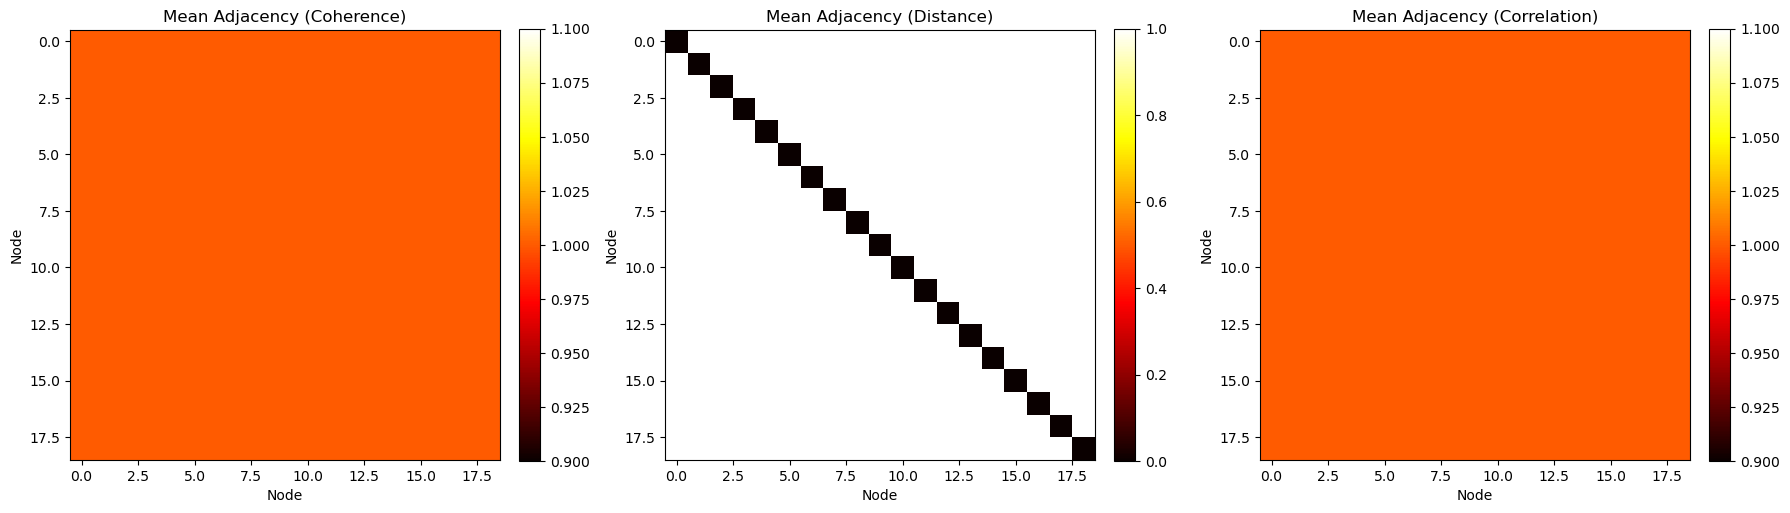

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj

# Calculate mean adjacency matrices
num_nodes = 19

adj_coherence = [to_dense_adj(g.edge_index, max_num_nodes=num_nodes)[0].numpy() for g in graph_coherence]
adj_distance = [to_dense_adj(g.edge_index, max_num_nodes=num_nodes)[0].numpy() for g in graph_distance]
adj_corr = [to_dense_adj(g.edge_index, max_num_nodes=num_nodes)[0].numpy() for g in graph_corr]

mean_adj_coherence = np.mean(adj_coherence, axis=0)
mean_adj_distance = np.mean(adj_distance, axis=0)
mean_adj_corr = np.mean(adj_corr, axis=0)

# Plot the three heatmaps side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

im0 = axs[0].imshow(mean_adj_coherence, cmap='hot', interpolation='nearest')
axs[0].set_title('Mean Adjacency (Coherence)')
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(mean_adj_distance, cmap='hot', interpolation='nearest')
axs[1].set_title('Mean Adjacency (Distance)')
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

im2 = axs[2].imshow(mean_adj_corr, cmap='hot', interpolation='nearest')
axs[2].set_title('Mean Adjacency (Correlation)')
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

for ax in axs:
    ax.set_xlabel('Node')
    ax.set_ylabel('Node')

plt.tight_layout()
plt.show()

In [ ]:
import mne


def create_mne_signal(eeg, sfreq, ch_names):
    """
    Create an MNE Raw object from EEG data.
    
    Parameters:
    eeg (numpy.ndarray): EEG data with shape (n_channels, n_samples).
    sfreq (float): Sampling frequency in Hz.
    ch_names (list of str): List of channel names.
    
    Returns:
    mne.io.Raw: MNE Raw object containing the EEG data.
    """
    eeg = eeg * 1e-6
    # Create MNE Info object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * len(ch_names))
    # Create Raw object
    raw = mne.io.RawArray(eeg, info, verbose=False)
    # Set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, verbose=False)
    return raw

def plot_eeg_sensors(eeg, sfreq, ch_names, title='EEG Topomap'):
    raw = create_mne_signal(eeg, sfreq, ch_names)
    
    # Plot sensors and get the figure
    fig = mne.viz.plot_sensors(raw.info, kind='topomap', show_names=True, show=True)
    
    # Add title to the actual figure
    fig.suptitle(title, fontsize=14)
    
    return fig

def plot_signal(eeg, sfreq, ch_names):
    n_channels = eeg.shape[0]
    raw = create_mne_signal(eeg, sfreq, ch_names=ch_names)
    raw.plot(n_channels=n_channels,duration=12, show_scrollbars=False, title='EEG Recording with 10-20 Montage');

def plot_topo(eeg, sfreq, ch_names):
    """
    Plot the topographic map of EEG sensors.
    
    Parameters:
    raw (mne.io.Raw): MNE Raw object containing the EEG data.
    """
    raw = create_mne_signal(eeg, sfreq, ch_names)
    spectrum = raw.compute_psd()
    fig = spectrum.plot_topomap()

    return fig
# Plot the EEG signal

In [ ]:
labels = data_train.get_label_array()

#get idx of class 0
idx_class_0 = np.where(labels == 0)[0]
idx_class_1 = np.where(labels == 1)[0]

eeg_0 = data_train[idx_class_0[1]][0].T
eeg_1 = data_train[idx_class_1[1]][0].T



In [ ]:
ch_names = [
        'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
        'T7', 'C3', 'Cz', 'C4', 'T8',
        'P7', 'P3', 'Pz', 'P4', 'P8',
        'O1', 'O2'
    ]

raw0 = create_mne_signal(eeg_0, 250, ch_names=ch_names)
raw1 = create_mne_signal(eeg_1, 250, ch_names=ch_names)

In [ ]:
fig = raw0.compute_psd(verbose=False).plot();
fig.savefig("psd_class_0.png")
fig = raw1.compute_psd(verbose=False).plot();
fig.savefig("psd_class_1.png")

Plotting power spectral density (dB=True).


/home/nulpe/anaconda3/envs/ada/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Plotting power spectral density (dB=True).


/home/nulpe/anaconda3/envs/ada/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


In [ ]:
raw0.compute_psd().plot();

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/home/nulpe/anaconda3/envs/ada/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


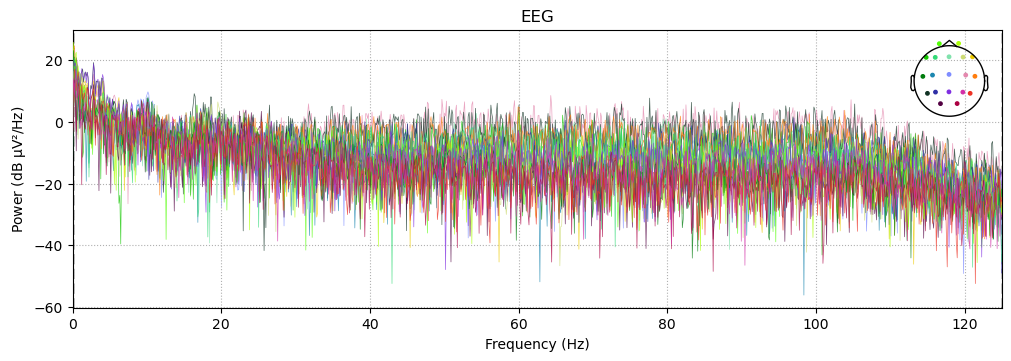

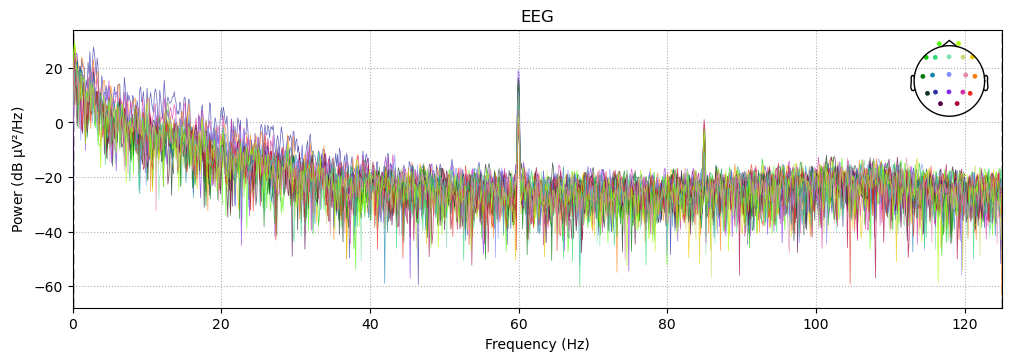

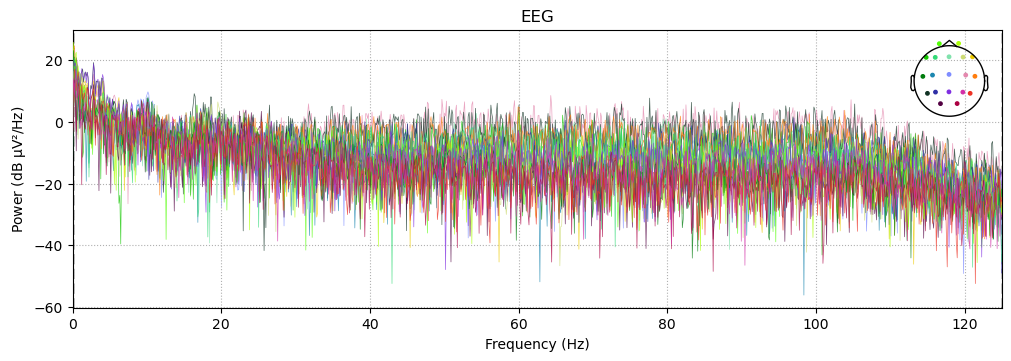

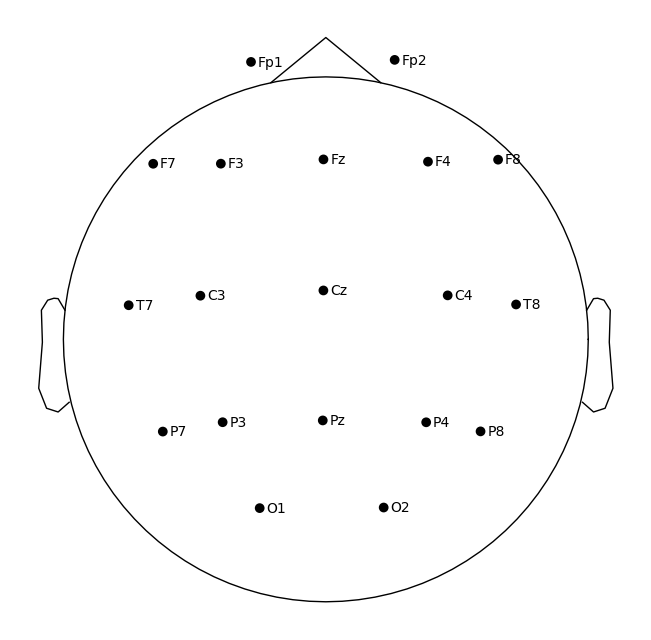

In [ ]:

sfreq = 250  # Sampling frequency in Hz
plot_eeg_sensors(eeg_0, sfreq, ch_names=ch_names);

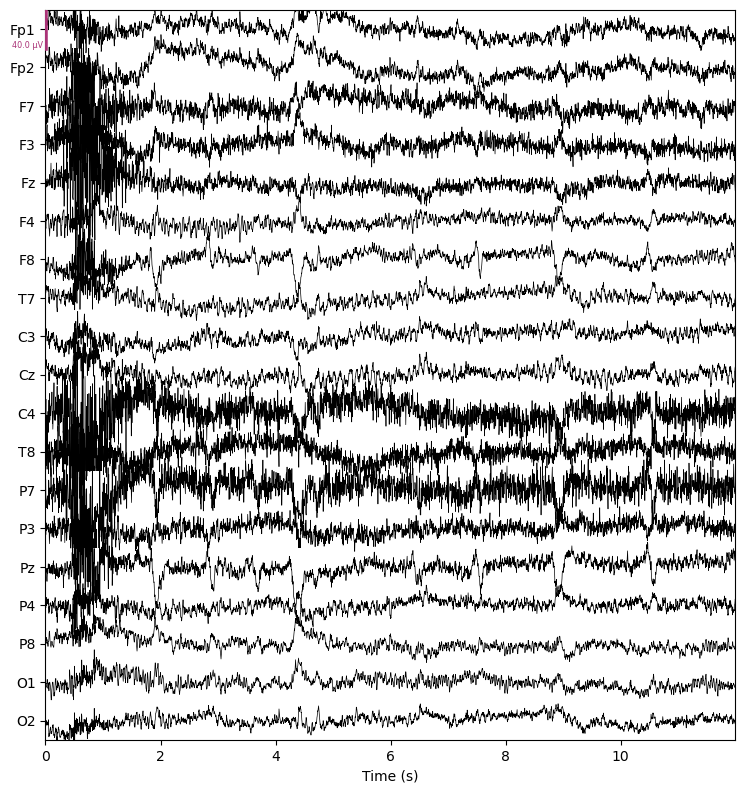

Effective window size : 8.192 (s)


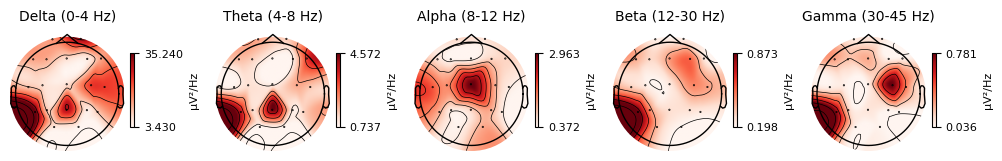

In [ ]:
plot_signal(eeg_0, sfreq, ch_names=ch_names);

plot_topo(eeg_0, sfreq, ch_names=ch_names);


Effective window size : 8.192 (s)


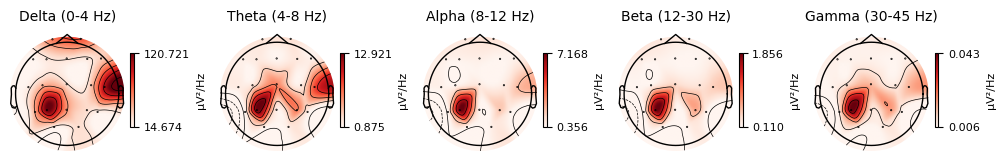

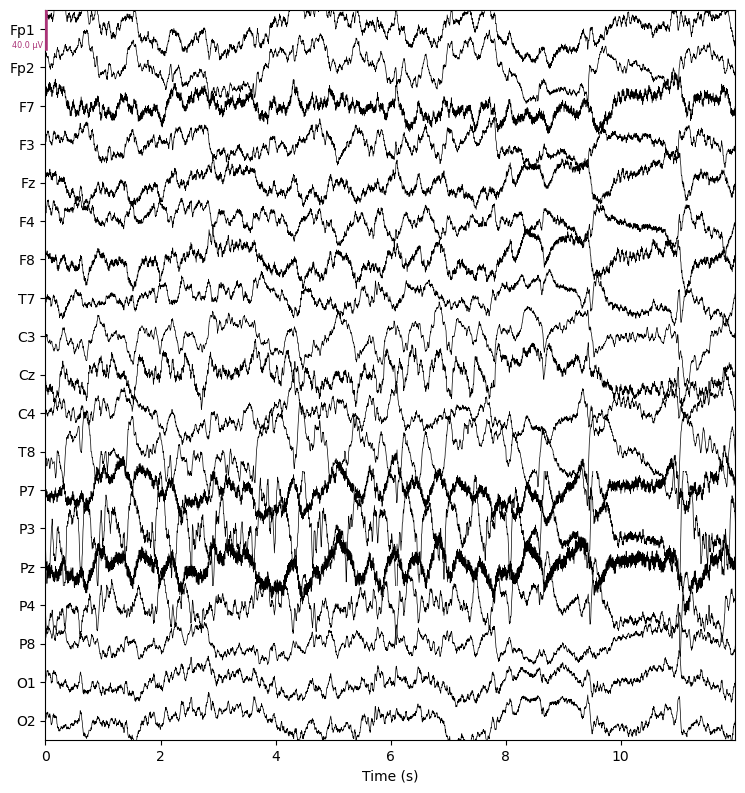

In [ ]:
plot_topo(eeg_1, sfreq, ch_names=ch_names);

plot_signal(eeg_1, sfreq, ch_names=ch_names);


In [ ]:
import numpy as np

def is_mostly_zero_record(eeg, threshold=0.2):
    """
    eeg: np.ndarray of shape (channels, time)
    threshold: fraction of the signal length that can be zero before we discard
    Returns True if the signal is mostly zeros at the beginning
    """
    # Sum absolute signal across channels => shape: (time,)
    signal_magnitude = np.sum(np.abs(eeg), axis=0)
    cumsum = np.cumsum(signal_magnitude)
    total = cumsum[-1]
    if total == 0:
        return True  # fully zero record

    # Find when at least 1% of total energy has accumulated
    start_idx = np.argmax(cumsum >= 0.01 * total)
    return (start_idx / eeg.shape[1]) > threshold

In [ ]:
clips_tr

label  start_time  end_time       date  \
patient  session   segment                                           
pqejgcff s001_t000 0            1         0.0      12.0 2003-01-01   
                   1            1        12.0      24.0 2003-01-01   
                   2            1        24.0      36.0 2003-01-01   
                   3            1        36.0      48.0 2003-01-01   
                   4            1        48.0      60.0 2003-01-01   
...                           ...         ...       ...        ...   
pqejgvqb s001_t013 8            1        96.0     108.0 2015-01-01   
                   9            1       108.0     120.0 2015-01-01   
                   10           1       120.0     132.0 2015-01-01   
                   11           1       132.0     144.0 2015-01-01   
                   12           0       144.0     156.0 2015-01-01   

                            sampling_rate                        signals_path  
patient  session   segment                                                     
pqejgcff s001_t000 0                  250  signals/pqejgcff_s001_t000.parquet  
                   1                  250  signals/pqejgcff_s001_t000.parquet  
                   2                  250  signals/pqejgcff_s001_t000.parquet  
                   3                  250  signals/pqejgcff_s001_t000.parquet  
                   4                  250  signals/pqejgcff_s001_t000.parquet  
...                                   ...                                 ...  
pqejgvqb s001_t013 8                  250  signals/pqejgvqb_s001_t013.parquet  
                   9                  250  signals/pqejgvqb_s001_t013.parquet  
                   10                 250  signals/pqejgvqb_s001_t013.parquet  
                   11                 250  signals/pqejgvqb_s001_t013.parquet  
                   12                 250  signals/pqejgvqb_s001_t013.parquet  

[12993 rows x 6 columns]

In [ ]:
eeg_1 = dataset_tr[idx_class_1[1]][0].T
records_to_keep = [idx for idx in idx_class_0 if not is_mostly_zero_record(dataset_tr[idx][0].T)]
records_to_delete = [idx for idx in idx_class_0 if is_mostly_zero_record(dataset_tr[idx][0].T)]

In [ ]:
len(records_to_delete)

32

In [ ]:
dataset_tr[4777]

(array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [ 65.13097018, -10.2474868 ,   4.40095828, ...,  20.880459  ,
         -56.32905362, -37.10296945],
        [ 74.36655782,  -1.92742698,   6.00714743, ...,  16.07795343,
         -62.65743889, -46.78829005],
        [ 75.52301401,   0.44973296,   3.19631642, ...,  15.70852992,
         -68.5200293 , -51.73535264]]),
 0)

: 